 # please re-start kernel if these packages are installed for the first time

In [ ]:
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/objFuncs_REA
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/pyBO

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from epics import caget

In [2]:
from objFuncs.REA_maximize_FC import maximize_FC1058 as maximize_FC
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

[20:42:43.828] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[20:42:43.829] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB
[20:42:43.831] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/phantasy.ini
[20:42:43.833] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


[20:42:44.027] INFO: phantasy.library.operation.lattice: UNICORN policy will be loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/unicorn/unicorn-data.xls.
[20:42:44.028] WARNING: phantasy.library.operation.lattice: No aligment data is read.
[20:42:44.029] INFO: phantasy.library.operation.lattice: Device polarity data is loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/polarity/polarity_data.csv.
[20:42:44.030] INFO: phantasy.library.operation.lattice: Loading PV data from CSV/SQLite: /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/linac/all_channels.csv
[20:42:44.031] INFO: phantasy.library.pv.datasource: Set source to be CSV table: all_channels.csv.
[20:42:44.566] INFO: phantasy.library.operation.lattice: Model data directory: /user/rea3/phantasy_data/20240311/model_data/data_204244
[20:42:44.613] INFO: phantasy.library.operation.lattice: Found 13828 PVs in 'LINAC'.
[20:42:46.632] INFO: phantasy.library.operation.lattice: 'LINAC' has 1353 e

In [3]:
from pyBO import pyBO

In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 4.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 0.25
# objFuncs._global_machineIO.fetch_data = objFuncs.construct_machineIO._manual_fetch_data

objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 4.05
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [6]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne9 A/Q= 2.2222222222222223


In [7]:
now0 = datetime.datetime.now()
now0str = str(now0)[:str(now0).rfind(':')].replace(' ','_').replace(':','').replace('-','')
fname = '[REA][pyBO]'+now0str+'_'+ion+'_FC1058'
fname

'[REA][pyBO]20240311_2043_20Ne9_FC1058'

# Decision parameters and range

In [8]:
decision_CSETs = [#'REA_BTS10:DCHE_D0948:V_CSET',
                  #'REA_BTS10:DCVE_D0948:V_CSET',
                  'REA_BTS19:DCHE_D0979:V_CSET',
                  'REA_BTS19:DCVE_D0970:V_CSET',
                  'REA_BTS19:DCHE_D0987:V_CSET',
                  #'REA_BTS19:DCVE_D0987:V_CSET',
                  'REA_BTS19:QE_D0981:V_CSET',
                  'REA_BTS19:QE_D0985:V_CSET',
                  'REA_BTS19:QE_D0987:V_CSET'
                  ]

In [9]:
ave,_ = objFuncs._global_machineIO.fetch_data(decision_CSETs,0.1)
#decision_min =  [-600, -600,  -300, -300, -1900,  850]
#decision_max =  [600,   600,   300,  300, -1600, 1250]
# decision_min = [-800, -400,  -200, -100, -1862,  940]
# decision_max = [-400,    0,   200,  100, -1662, 1140]
decision_min = np.round(ave - 200)
decision_max = np.round(ave + 200)
decision_tols = [2,2,2,2,2,2]
pd.DataFrame([decision_min,decision_max,decision_tols],columns=decision_CSETs,index=['min','max','tol']).T

,min,max,tol
REA_BTS19:DCHE_D0979:V_CSET,-259.0,141.0,2.0
REA_BTS19:DCVE_D0970:V_CSET,-262.0,138.0,2.0
REA_BTS19:DCHE_D0987:V_CSET,-217.0,183.0,2.0
REA_BTS19:QE_D0981:V_CSET,-2082.0,-1682.0,2.0
REA_BTS19:QE_D0985:V_CSET,830.0,1230.0,2.0
REA_BTS19:QE_D0987:V_CSET,-1629.0,-1229.0,2.0


In [ ]:
# STC = 150.
# STC1=50.
# STC2=STC
# STC3=STC
# STC4=STC

# decision_min = [-STC1*AQ,-STC2*AQ,-STC3*AQ,-STC4*AQ]
# decision_max = [STC1*AQ,STC2*AQ,STC3*AQ,STC4*AQ]

# decision_min = [-800, -400,  -200, -100, -1862,  940]
# decision_max = [-400,    0,   200,  100, -1662, 1140]
#decision_tols = None
# decision_tols = [2,2,2,2,2,2]
# print(decision_min)
# print(decision_max)
# print(decision_tols)

In [10]:
assert len(decision_CSETs) == len(decision_min) == len(decision_max)
if decision_tols is not None:
    assert len(decision_CSETs) == len(decision_tols) 
assert np.all(np.array(decision_min)<np.array(decision_max))

# Objectives

### manual definition of obj

In [14]:
FC0999 = 90e-12
FC='REA_BTS19:MTER_N0001:I_RD'
FC='REA_WK01:FC_D1058:BC_RD'
objective_goal   = {FC: {'more than': FC0999}}
objective_weight = {FC: 1}
objective_norm   = {FC: 0.2*FC0999}
# objective_goal   = {'REA_WK01:FC_D1058:BC_RD': {'more than': FC0999}}
# objective_weight = {'REA_WK01:FC_D1058:BC_RD': 1}
# objective_norm   = {'REA_WK01:FC_D1058:BC_RD': 1e-12}

In [15]:
objFuncs._global_machineIO.caget(FC)/1e-12

43.13174123415919

### regularization

In [ ]:
# reg_goal = {key:0.5*(val_max+val_min) if 'PSD' in key else 0 for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_norm = {key:0.5*(val_max-val_min) for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_weight = {key:0.1 if 'PSD' in key else 0.05 for key in decision_CSETs}   

In [ ]:
# objective_goal.update(reg_goal)
# objective_norm.update(reg_norm)
# objective_weight.update(reg_weight)

In [ ]:
# pd.DataFrame((objective_goal,objective_norm,objective_weight),index=['goal','norm','weight']).T

### construct objectives class

In [16]:
obj = maximize_FC(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    objective_fill_none_by_init = True,
)

======== class info ========
init_time: 2024-03-11 20:43:30.172682
class_hierarchy: [
    maximize_FC1058, maximize_FC, objFuncGoals
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f85af0a7fd0>
decision_CSETs: [
    REA_BTS19:DCHE_D0979:V_CSET, REA_BTS19:DCVE_D0970:V_CSET, REA_BTS19:DCHE_D0987:V_CSET
    REA_BTS19:QE_D0981:V_CSET, REA_BTS19:QE_D0985:V_CSET, REA_BTS19:QE_D0987:V_CSET]
decision_min: [ -259.  -262.  -217. -2082.   830. -1629.]
decision_max: [  141.   138.   183. -1682.  1230. -1229.]
decision_bounds : array of shape (6, 2) and type float64
decision_RDs: [
    REA_BTS19:DCHE_D0979:V_RD, REA_BTS19:DCVE_D0970:V_RD, REA_BTS19:DCHE_D0987:V_RD
    REA_BTS19:QE_D0981:V_RD, REA_BTS19:QE_D0985:V_RD, REA_BTS19:QE_D0987:V_RD]
decision_tols: [2 2 2 2 2 2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [  -58.84896383   -61.73338127   -17.18496832 -1881.64253218
  1030.10503125 

 # Prepare plot callbacks

In [17]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]


# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO

### initialize BO near current set

In [18]:
x0,_ = objFuncs._global_machineIO.fetch_data(decision_CSETs,0.1)
local_min = x0 - 0.1*(obj.decision_max - obj.decision_min)
local_max = x0 + 0.1*(obj.decision_max - obj.decision_min)
local_bounds = list(zip(local_min,local_max))
x0, local_bounds

(array([  -58.84896383,   -61.73338127,   -17.18496832, -1881.64253218,
         1030.10503125, -1429.        ]),
 [(-98.84896382924893, -18.84896382924893),
  (-101.73338126830102, -21.733381268301017),
  (-57.184968324559435, 22.815031675440565),
  (-1921.64253217732, -1841.64253217732),
  (990.1050312513448, 1070.1050312513448),
  (-1469.0, -1389.0)])

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


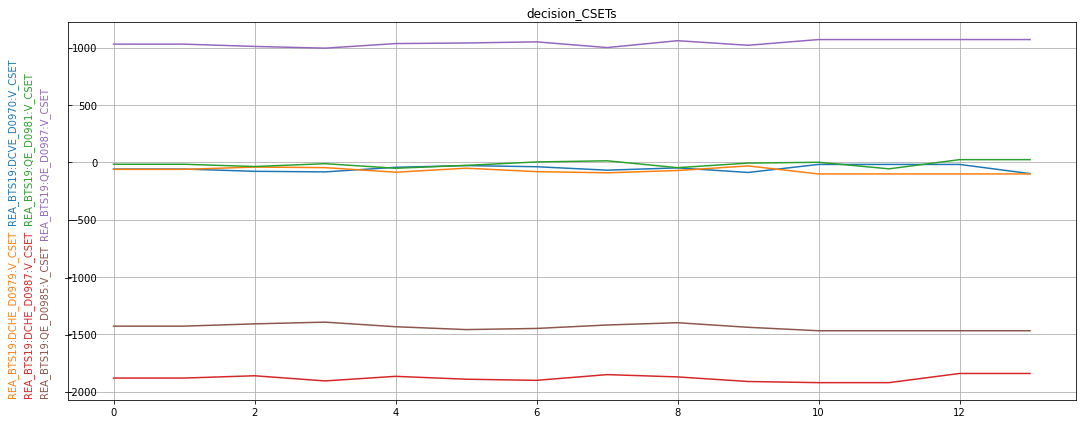

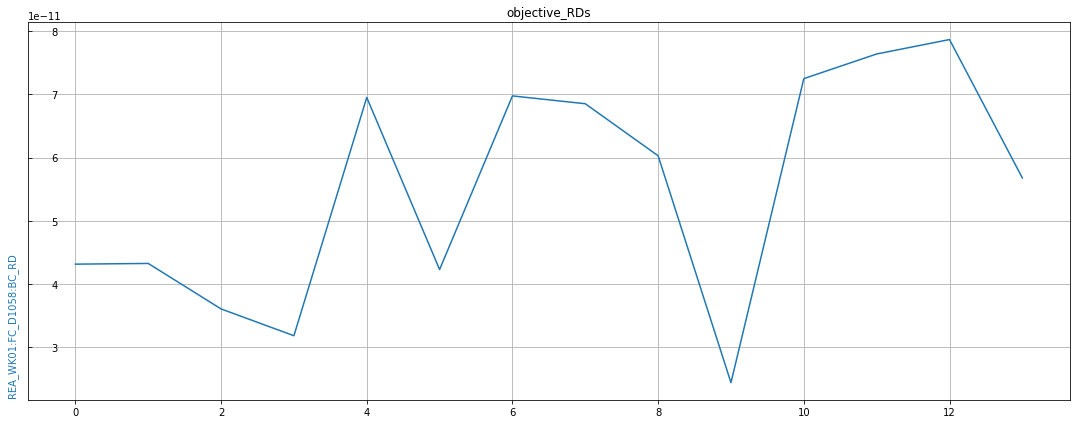

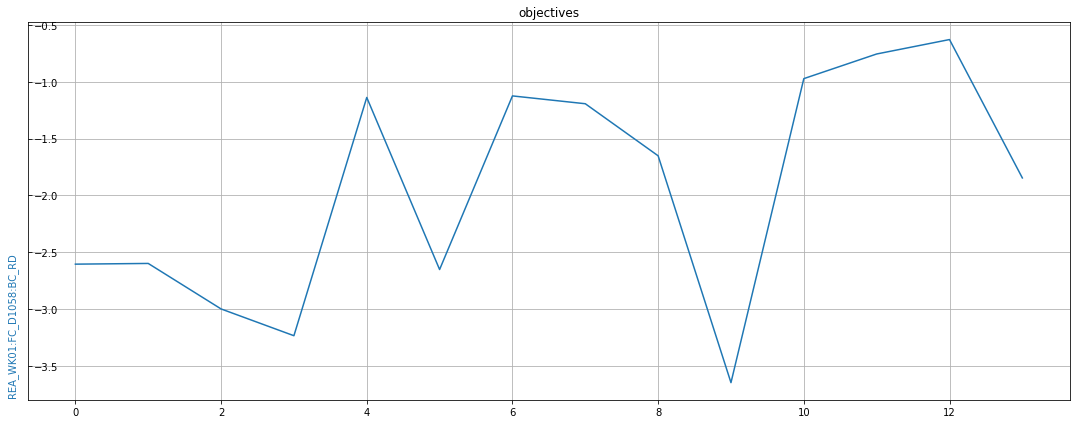

x data has duplicates. will remove duplicates and will average corresponding ys
x: [  -58.84896383   -61.73338127   -17.18496832 -1881.64253218
  1030.10503125 -1429.        ] corresponding ys: [-2.60365216 -2.59743699]
[████████████████████████████████████████] 100%/100%



In [19]:
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=local_bounds,
                                    n_init=10,
                                    x0 = obj.x0,
                                    budget = 12,
                                    batch_size=1,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

In [20]:
budget = 60

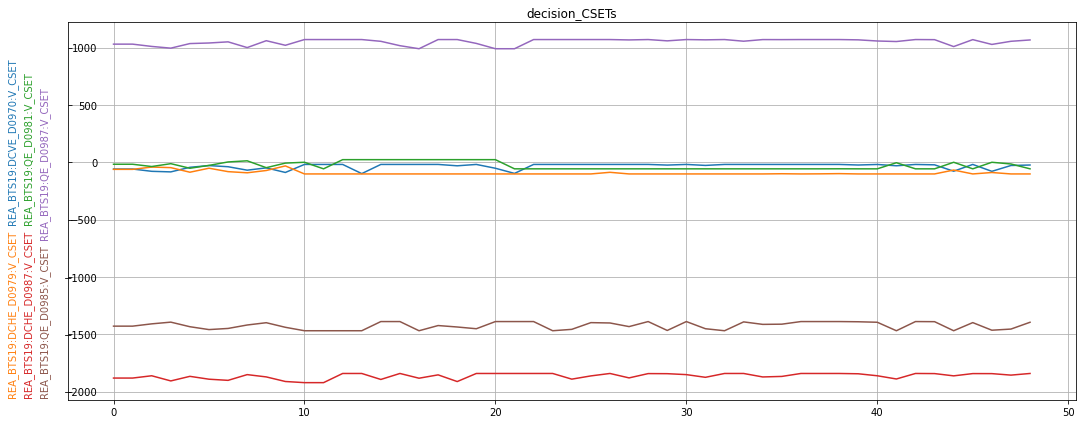

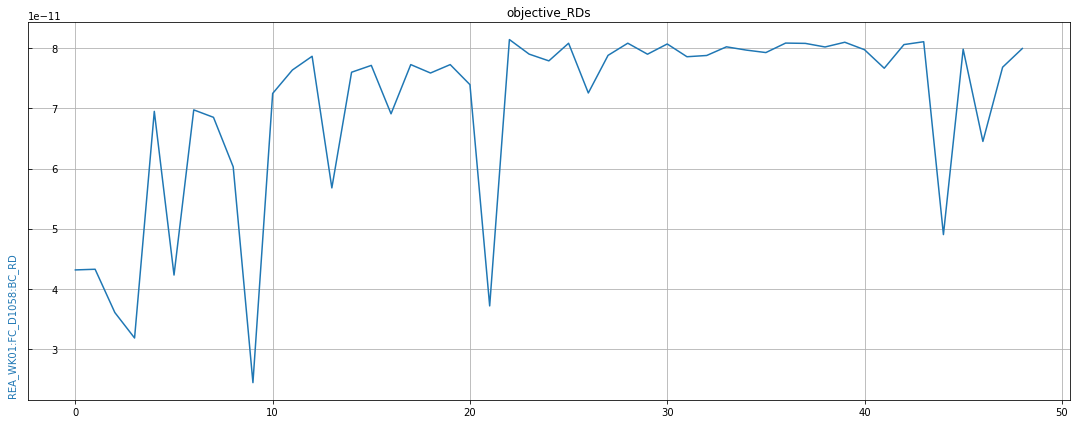

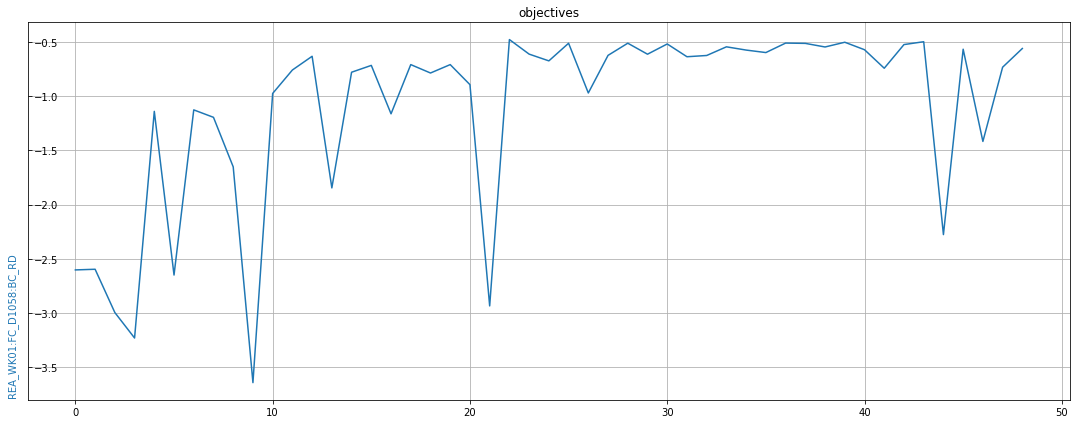

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



[████████████████████████████████████████] 100%/100%



AttributeError: x

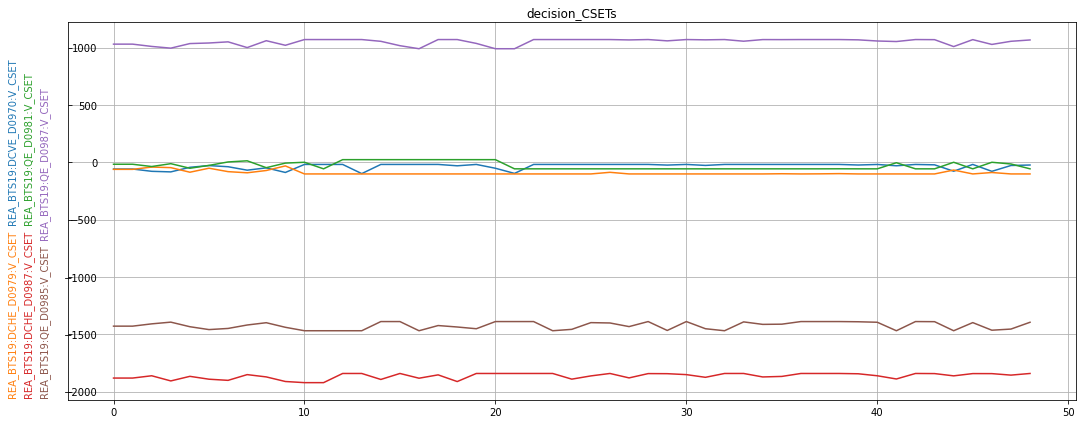

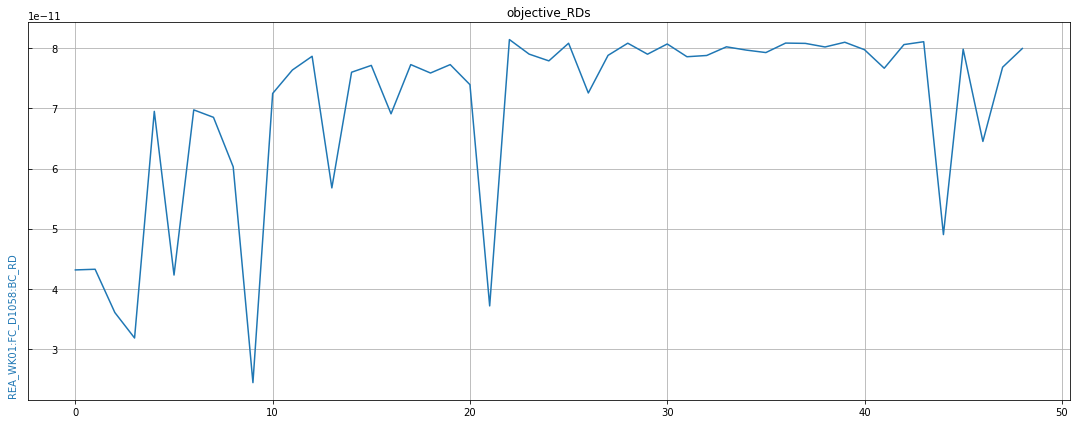

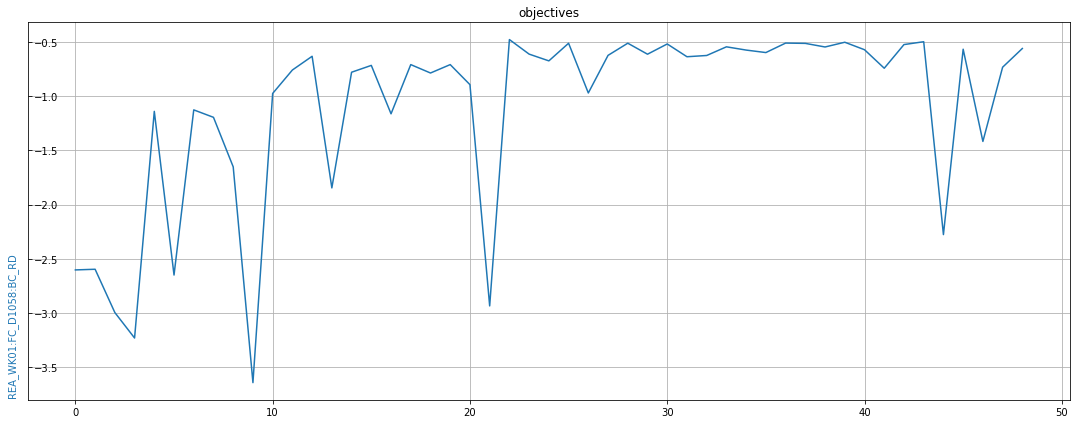

In [21]:
# uncomment and run if more iteration needed
acquisition_func_args = {'beta':9}
betas = np.linspace(4,1,budget)

while(len(bo.y) < budget):
    x0,y0 = bo.best_sofar()
    local_min = x0 - 0.1*(decision_max - decision_min)
    local_max = x0 + 0.1*(decision_max - decision_min)
    local_bounds = list(zip(local_min,local_max))
    beta = betas[len(bo.y)]
    acquisition_func_args['beta'] = beta
    
    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=3,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    acquisition_func_args = acquisition_func_args,
                                    batch_size = 1,
                                    write_log = False,
                                    )
for f in callbacks:
    f.close()

In [ ]:
x0,y0 = bo.best_sofar()
local_min = x0 - 0.1*(decision_max - decision_min)
local_max = x0 + 0.1*(decision_max - decision_min)
local_bounds = list(zip(local_min,local_max))
beta = 0.1
acquisition_func_args['beta'] = beta

X_pending, Y_pending_future= bo.loop( 
                                n_loop=3,  # number of additional optimization interation
                                func_obj = obj_callbacks,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                acquisition_func_args = acquisition_func_args,
                                batch_size = 1,
                                write_log = False,
                                )
for f in callbacks:
    f.close()

In [ ]:
# if python raised error, use the following to re-use all the data until now
# bo, X_pending, Y_pending_future = pyBO.runBO(
#     obj_callbacks,  
#     bounds=obj.decision_bounds,
#     n_init=n_init,
#     x0 = np.array(obj.history['decision_RDs']['values']),
#     y0 = np.array(obj.history['objectives']['values']),
#     budget = budget,
#     batch_size=1,
#     path="./log/",
#     tag=fname+'_pyBO_history',
#     write_log = False)
# for f in callbacks:
#     f.close()

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
ax = bo.plot_obj_history(ax=ax,plot_best_only=True)
# ax.vlines(n_init,*ax.get_ylim(),color='k')
fig.tight_layout()
# fig.savefig(fname+'_history.png',dpi=90)

In [22]:
# set to best solution 
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[  -18.84896383  -101.73338127   -57.18496832 -1841.64253218
  1070.10503125 -1389.        ] -0.47502630058918577 -0.49350174676192515


# Visualize Surrogate model

In [ ]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None              # do not fix values but project maximum. Can take long time to plot
batch_size = 1

In [ ]:
for i in range(int(len(decision_CSETs)/2)):
    fig,ax = plt.subplots(figsize=(4,3))
    bo.plot_model_2D_projection(project_maximum=True,
                                dim_xaxis = 2*i,
                                dim_yaxis = 2*i+1,
                                grid_ponits_each_dim = 16,
                                fixed_values_for_each_dim=fixed_values_for_each_dim,
                                fig=fig,ax=ax);
    ax.legend()
    pv_x = obj.decision_CSETs[2*i]
    pv_y = obj.decision_CSETs[2*i+1]
    pv_x = pv_x[pv_x.find(':')+1:]
    pv_y = pv_y[pv_y.find(':')+1:]
    pv_x = pv_x[:pv_x.find(':')].replace('_D','')
    pv_y = pv_y[:pv_y.find(':')].replace('_D','')
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    fig.tight_layout()
#     fig.savefig(fname+'_'+pv_x+'_'+pv_y+'_.png',dpi=90)

In [ ]:
pd.DataFrame([x_best],columns=decision_CSETs,index=['solution']).T